# **IMAGE CLASSIFICATOR WITH PSO FOR HYPERPARAMETERS OPTIMIZATION**

## Definition of the problem and main goal
In this notebook we want to write a Convolutional Neural Network (CNN) with the aim of classify the images taken by the **CIFAR-10** dataset. Moreover we want to use **Particle Swarm Optimization** (PSO) in order to optimize some characteristics of the CNN concerning architecture and hyperparameters. The PSO has been implemented by us as a class called *INSERIRE NOME CLASSE

## CIFAR-10 dataset preprocessing
Quoting directly the official webpage (https://www.cs.toronto.edu/~kriz/cifar.html):
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<img src="Immagine 2023-02-08 183815.png" alt="drawing" width="50%" height="40%"/>

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks."

By looking the webpage we know we can use the **unpickle** function for opening the 5 batches files:

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

As written on the webpage:

"Loaded in this way, each of the batch files contains a dictionary with the following elements:
- **data**: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
- **labels**: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array **data**.

The dataset contains another file, called **batches.meta**. It too contains a Python dictionary object. It has the following entries:
- **label_names** -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc."


https://medium.com/@rhythm10/image-preprocessing-for-cifar-10-dataset-f2b5cdb221bb

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import matplotlib.pyplot as plt
import time

 From the five training data files, we are first going to unpickle the data and then read it from the directory that the data has been stored at. We read the five data files by iterating over a loop to provide the name of the data file stored in the directory.

Similarly, for testing data, we first unpickle the data and read it.

In [11]:
def load_data(data_dir):
    #load training data 
    for i in range(1, 6): 
        filename = data_dir+"/data_batch_"+str(i) 
        dictionary = unpickle(filename) 
        x_data = dictionary[b'data']  
        y_data = np.array(dictionary[b"labels"])
        if i==1:   
            x_train = x_data  
            y_train= y_data  
        else:  
            x_train = np.concatenate((x_train, x_data), axis = 0)   
            y_train = np.concatenate((y_train, y_data), axis = 0)  

    #load testing data 
    filename = data_dir+"/test_batch" 
    dictionary = unpickle(filename)
    data = dictionary[b"data"]
    x_test = data 
    y_test = np.array(dictionary[b"labels"]) 
    return x_train, y_train, x_test, y_test

In [12]:
def train_valid_split(x_train, y_train, split_index=45000):
    '''split the input data based on the split index'''
    x_train_new = x_train[:split_index] 
    y_train_new = y_train[:split_index] 
    x_valid = x_train[split_index:] 
    y_valid = y_train[split_index:]
    return x_train_new, y_train_new, x_valid, y_valid

After having defined the function we need, we can apply them to our files.

In [13]:
data_dir = "cifar-10-batches-py"
x_train, y_train, x_test, y_test = load_data(data_dir)

#Let's split the train data into two sets: training and validation:
x_train, y_train, x_valid, y_valid = train_valid_split(x_train, y_train, split_index=45000)

print('The train dataset has:' , x_train.shape[0], 'element \n', 'The validation dataset has:' , x_valid.shape[0], 'element \n', 'The test dataset has:' , x_test.shape[0], 'element \n',)

print('The length of a single element is: ', x_train.shape[1])

The train dataset has: 45000 element 
 The validation dataset has: 5000 element 
 The test dataset has: 10000 element 

The length of a single element is:  3072


We first are going to parse our records in the data. Converting the image format from (depth * height * width) to first (depth ,height,width) and then to (width, height, depth)

In [14]:
def parse_record(record, training=True):
    '''Takes as input record which is an array of shape [3072,] and training which is a boolean variable used to determine if the process is in training mode and returns an array of shape [32,32,3]'''
    depth_major = record.reshape((3, 32, 32))
    image = np.transpose(depth_major, [1, 2, 0])
    #image = preprocess_image(image, training)
    return image

In [15]:
#Notice that before applying the parse_record function, the data shape is 45000 (number of image in the train) and 3072 that is 3*32*32 (depth*height*width)
x_train.shape

(45000, 3072)

In [16]:
train=[]
for img in x_train:
    train.append(parse_record(img))

valid=[]
for img in x_valid:
    valid.append(parse_record(img))

test=[]
for img in x_test:
    test.append(parse_record(img))

#Now we can see that the shape is no more 3072 but (32,32,3): (width, height, depth)
np.array(train).shape

(45000, 32, 32, 3)

In [17]:
new_train = [skimage.transform.resize(image, (64,64), mode = 'constant') for image in train]
new_test = [skimage.transform.resize(image, (64,64), mode = 'constant') for image in test]
new_valid = [skimage.transform.resize(image, (64,64), mode = 'constant') for image in valid]

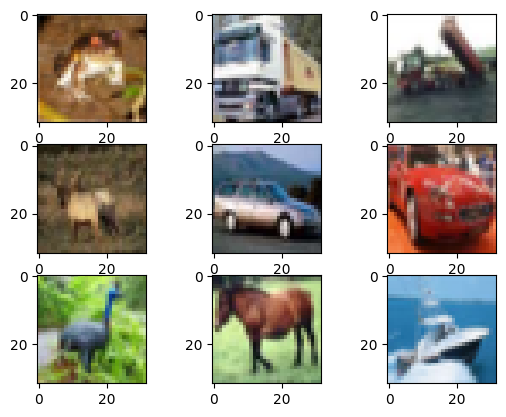

In [33]:
for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(train[i])
plt.show()

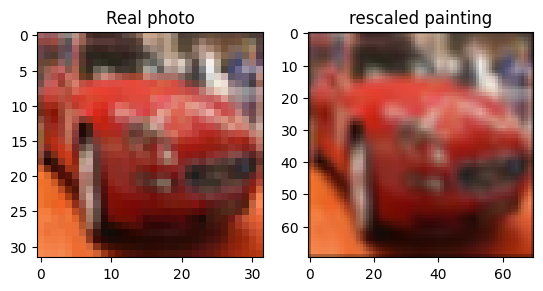

In [32]:
# Visualizing the real photo
plt.subplot(121)
plt.title('Real photo')
plt.imshow(train[5])

# Visualizing the Monet painting
plt.subplot(122)
plt.title('rescaled painting')
plt.imshow(new_train[5], interpolation = 'none')

In [ ]:
#DATA AGUMENTATION


In [34]:
# WE NEED TO NORMALIZE DATA
# for dataset in [train, valid, test]:
#     dataset = dataset.astype('float32')
#     dataset = dataset/255.
#     dataset_mean = np.mean(dataset)
#     dataset = dataset - dataset_mean
    

AttributeError: 'list' object has no attribute 'astype'

In [10]:
# The label data is just a list of 10,000 numbers ranging from 0 to 9, which corresponds to each of the 10 classes in CIFAR-10.
# airplane : 0, automobile : 1, bird : 2, cat : 3, deer : 4, dog : 5, frog : 6, horse : 7, ship : 8, truck : 9
# We need to encode the target variable
#FNIODHVNCKNAERIFOCJURAEPDLCV
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)

## CNN 

We decide to use the AlexNet as landmark.
The architecture consists of 5 Convolutional layers, with the 1st, 2nd and 5th having Max-Pooling layers for proper feature extraction. The Max-Pooling layers are overlapped having strides of 2 with filter size 3×3. They are followed by 2 fully-connected layers (each with dropout) and a softmax layer at the end for predictions.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

ModuleNotFoundError: No module named 'tensorflow.python'

Let's build the AlexNet architecture

In [ ]:
model = Sequential()
  
# 1st Convolutional Layer
model.add(Conv2D(filters = 64, input_shape = (32, 32, 3), 
            kernel_size = (3, 3), strides = (2, 2), 
            padding = 'valid'))
model.add(Activation('relu'))
# Max-Pooling 
model.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2), padding = 'valid'))
# Batch Normalisation
model.add(BatchNormalization())
  

# 2nd Convolutional Layer
model.add(Conv2D(filters = 192, kernel_size = (3, 3), 
            strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), 
            padding = 'valid'))
# Batch Normalisation
model.add(BatchNormalization())
  

# 3rd Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3, 3), 
            strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
  

# 4th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3, 3), 
            strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
  

# 5th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3, 3), 
            strides = (1, 1), padding = 'valid'))
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), 
            padding = 'valid'))
# Batch Normalisation
model.add(BatchNormalization())


# Flattening
model.add(Flatten())
  
# 1st Dense Layer
model.add(Dense(4096, input_shape = (224*224*3, )))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())
  
# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())
  
# Output Softmax Layer
model.add(Dense(10))
model.add(Activation('softmax'))


## Forse si può fare direttamente da qua
# import torchvision.models as models
# squeezenet = models.alexnet(pretrained=True)

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

model.summary()


In [ ]:
# Let's train the model

start_time = time.perf_counter()

training = model.fit(x_train, y_train, batch_size=64,epochs=100,verbose=1,validation_data=(x_valid, y_valid))

print("Execution time:", time.perf_counter() - start_time)

In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

We plot the accuracy and loss plots between training and validation data

In [ ]:
accuracy = training.history['acc']
val_accuracy = training.history['val_acc']
loss = training.history['loss']
val_loss = training.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()